In [ ]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
# ! pip install sklearn-pandas
from sklearn_pandas import DataFrameMapper

import torch
import torchtuples as tt

import optuna
# from ray import tune
# from ray.tune.schedulers import ASHAScheduler
import warnings
warnings.filterwarnings("ignore")

os.chdir("../")
from pycox.models.cox import CoxPH#, CoxPHStratified
from pycox.evaluation.eval_surv import EvalSurv#, EvalurvStratified
from scr.utils import *
from scr.runDeepSurvModels import *

np.random.seed(1234)
_ = torch.manual_seed(123)

## Optuna

### Network Setup

In [ ]:
def parse_hyperparameters(trial, config=None):
    """
    Convert a dictionary of hyperparameter ranges into Optuna-compatible format.
    
    Args:
    - trial (optuna.trial.Trial): The Optuna trial object to sample parameters from.
    - hyperparam_dict (dict): A dictionary with hyperparameter names as keys. Values should be a dictionary specifying the type of parameter ('int', 'float', or 'categorical')
    and the range or choices.
    
    Returns:
    - dict: A dictionary of sampled hyperparameters compatible with the given ranges.
    """
    # config = self.hyperparameters if config is None else config
    params = {}
    for param_name, param_info in config.items():
        param_type = param_info.get("type")
        if param_type == "int":
            params[param_name] = trial.suggest_int(param_name, param_info["low"], param_info["high"])
        elif param_type == "float":
            params[param_name] = trial.suggest_float(param_name, param_info["low"], param_info["high"], log=param_info.get("log", False))
        elif param_type == "categorical":
            params[param_name] = trial.suggest_categorical(param_name, param_info["choices"])
        else:
            raise ValueError(f"Unsupported hyperparameter type: {param_type}")
    return params


from abc import ABC
class DeepSurvPipeline(ABC):
    def __init__(self, train_df, test_df, 
                time_col='time', status_col='status',
                dataName=None, hyperparameters=None, random_state=42):
        self.train_df=train_df
        self.test_df=test_df
        self.n = train_df.shape[0]
        self.time_col = time_col
        self.status_col = status_col
        self.dataName = dataName
        self.hyperparameters = hyperparameters
        self.random_state = random_state
        self.model = None
        self.modelString = 'deepsurv-torch'
    
    def _preprocess_data(self, df):
        """Use StandardScaler() to transform input miRNA data.
        Return transformed features and labels (survival time and censor status) separately.
        """
        survival_cols = [self.time_col, self.status_col]
        covariate_cols = [col for col in df.columns if col not in survival_cols]
        standardize = [([col], StandardScaler()) for col in covariate_cols]
        x_mapper = DataFrameMapper(standardize)

        # transform features (miRNA expression)
        x = x_mapper.fit_transform(df[covariate_cols]).astype('float32')
        # prepare labels (survival data)
        get_target = lambda df: (df[self.time_col].values, df[self.status_col].values)
        y = get_target(df)
        
        return x, y
    
    def train_mlp(self, train_df, val_df, params, patience, min_delta, verbose=False, is_tuning=False):
        """Training function that works for both tuning and main training.

        Args:
            x_train (pandas DataFrame): _description_
            y_train (pandas DataFrame): _description_
            params (dictionary): neural network training parameters
                - 'batch_size': batch size
                - 'epochs': number of training epochs
                - 'num_nodes': hidden layer size
                - 'learning_rate'
                - 'dropout'
                - ...
        """
        # Set hyperparameters with default values
        num_nodes = params.get("num_nodes", [16,16])            # Default to [16,16] if not provided
        dropout = params.get("dropout", 0.5)                    # Default dropout rate
        learning_rate = params.get("learning_rate", 1e-3)       # Default learning rate
        batch_size = params.get("batch_size", 32)               # Default batch size
        epochs = params.get("epochs", 100)                      # Default number of epochs
        batch_norm = params.get("batch_norm", True)             # Default batch normalization
        output_bias = params.get("output_bias", True)           # Default output bias
        
        # Prepare data 
        x_train, y_train = self._preprocess_data(train_df)
        val = self._preprocess_data(val_df)
        x_val, y_val = val
        input_size = x_train.shape[1]
        output_size = 1
        
        # =================== Build Neural Net ===================
        ## define network
        net = tt.practical.MLPVanilla(in_features=input_size,
                                    out_features=output_size,
                                    num_nodes=num_nodes,
                                    dropout=dropout, 
                                    batch_norm=batch_norm,
                                    # activation=nn.ReLu,
                                    output_bias=output_bias)
        # define optimizer 
        optimizer = tt.optim.Adam(weight_decay=0.01)
        model = CoxPH(net, optimizer)
        model.optimizer.set_lr(learning_rate)

        # =================== Train Model =====================
        callbacks = [tt.callbacks.EarlyStopping(patience=patience, min_delta=min_delta)]
        
        start = time.time() # Record iteration start time
        log = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        callbacks=callbacks, 
                        verbose=verbose,
                        val_data=val,
                        val_batch_size=batch_size
                        )
        stop = time.time() # Record time when training finished
        duration = round(stop - start, 2)
        
        # =================== Evaluation ===================
        _ = model.compute_baseline_hazards()
        val_surv = model.predict_surv_df(x_val)
        val_c_index  = EvalSurv(val_surv, y_val[0], y_val[1], censor_surv='km').concordance_td() 
        
        tr_surv = model.predict_surv_df(x_train)
        tr_c_index  = EvalSurv(tr_surv, y_train[0], y_train[1], censor_surv='km').concordance_td() 
        
        if not is_tuning:
            self.model = model
            self.optimizer = optimizer
            
        return duration, tr_c_index, val_c_index
    
    
    def _objective(self, trial, train_df, config, fixed_params=None, n_splits=5):
        """Perform K-Fold CV and return the average validation loss across folds.""" 
        
        tunable_params = parse_hyperparameters(trial, config=config)
        
        full_params = {**fixed_params, **tunable_params} if fixed_params else tunable_params
        
        kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=self.random_state)
        val_c_indexes = []

        for train_index, val_index in kf.split(train_df, train_df[self.status_col]):
            tr_df, val_df = train_df.iloc[train_index,:], train_df.iloc[val_index,:]

            # Train and evaluate on the current fold -- validation score
            *_, val_c_index = self.train_mlp(tr_df, val_df,
                                            params=full_params,
                                            patience=10, min_delta=1e-2,
                                            verbose=False,
                                            is_tuning=True)
            val_c_indexes.append(val_c_index)
        
        return np.mean(val_c_indexes)
    
    
    def tune_hyperparameters(self, train_df, 
                            config=None,
                            storage_url=None, study_name=None,
                            trial_threshold=20,
                            n_splits=5, n_trials=20, n_jobs=2):
        """
        Perform hyperparameter tuning with K-Fold CV, tuning only parameters 
        not already optimized in the existing study.
        
        Args:
            train_df: Training dataset.
            config: Search grid for hyperparameter tuning.
            storage_url: URL for Optuna storage.
            study_name: Name of the study.
            n_splits: Number of splits for cross-validation.
            n_trials: Number of trials to run for tuning.
            n_jobs: Number of parallel jobs for tuning.
            trial_threshold: Minimum number of trials required to skip tuning.
        """
        storage_url = "sqlite:///deepsurv-torch-hp-log.db" if storage_url is None else storage_url
        study_name = f"{self.dataName}-{self.train_df.shape[0]}" if study_name is None else study_name
        
        # Create an Optuna study for hyperparameter optimization
        study = optuna.create_study(direction='maximize', 
                                    storage=storage_url, study_name=study_name, load_if_exists=True)
        
        # Define search space
        config = self.hyperparameters if config is None else config
        if config is None:
            raise ValueError("No hyperparameter search space provided. Set `config` or `self.hyperparameters`.")

        # Extract already optimized hyperparameters and prepare new hyperparameter search grid
        fixed_params = study.best_params if len(study.trials) >= trial_threshold else {}
        new_config = {k: v for k, v in config.items() if k not in fixed_params}

        if len(new_config) == 0:
            print("All hyperparameters already tuned. Skipping optimization...")
            self.best_params = fixed_params
            return study
            
        # Optimize the study using the objective function
        print(f"Tuning parameters: {new_config}")
        print(f"Fixed parameters during tuning: {fixed_params}")
        
        study.optimize(lambda trial: self._objective(trial,
                                                    train_df=train_df,
                                                    config=new_config,
                                                    fixed_params=fixed_params,
                                                    n_splits=n_splits),
                            n_trials=n_trials, 
                            n_jobs=n_jobs)
        
        # Save the best hyperparameters
        self.best_params = {**fixed_params, **study.best_params}
        print(f"Best trial parameters: {self.best_params}")
        return study
        
        
    def train_with_best_params(self, val_size=0.2, 
                            params=None, 
                            patience=25, min_delta=1e-2,
                            verbose=True, print_scores=False):
        """
        Args:
            subset (_type_): _description_
            batch_sizes (_type_): _description_
            val_size (float, optional): _description_. Defaults to 0.2.
            kwargs (_type_, optional): _description_. Defaults to None.
            time_col (str, optional): _description_. Defaults to 'time'.
            status_col (str, optional): _description_. Defaults to 'status'.
            verbose (bool, optional): _description_. Defaults to True.
            print_scores (bool, optional): _description_. Defaults to False.

        Returns:
            _type_: _description_
        """
        if params is None and self.best_params is None:
            raise ValueError("No hyperparameters found. Run tune_hyperparameters() first or define them manually.")
        elif params is None:
            params = self.best_params
        
        # ===================== Prepare Data =======================
        tr_df, val_df = train_test_split(self.train_df, 
                                        test_size=val_size,
                                        shuffle=True, random_state=self.random_state,
                                        stratify=self.train_df[self.status_col])
        
        # ===================== Train Model =====================
        duration, train_c, _ = self.train_mlp(tr_df, val_df, params=params, 
                                            patience=patience, min_delta=min_delta,
                                            verbose=verbose, is_tuning=False)

        # ===================== Evaluation =====================
        x_test, y_test = self._preprocess_data(self.test_df)
        te_surv = self.model.predict_surv_df(x_test)
        test_c  = EvalSurv(te_surv, y_test[0], y_test[1], censor_surv='km').concordance_td()
        
        if print_scores:
            print(f"N={self.n} Training time ({duration}s): Train C-Index: {round(train_c,3)} | Test C-index: {round(test_c,3)}")
            
        return duration, train_c, test_c
    
    
    def write(self, model_results, out_dir=None, fileName='model.results.txt'):
        
        out_dir=os.path.join('models', self.dataName, self.modelString) if out_dir is None else out_dir
        os.makedirs(out_dir, exist_ok=True)
        
        # save results as txt or csv file
        if 'txt' in fileName:
            model_results.to_csv(os.path.join(out_dir,fileName), sep='\t')
        elif 'csv' in fileName:
            model_results.to_csv(os.path.join(out_dir,fileName), index=False)
        else:
            print('Please specify a file name with either a txt or csv extension.')  

### *Test: Hyperparameter Search*

In [23]:
## Parameter setup
# Load data
folder = 'linear'
keywords = ['moderate', "latest", 'RW']
DATANAME = 'linear-moderate'
train_df, test_df = load_simulate_survival_data(folder=folder, keywords=keywords, test_size=0.1)

print(f"Training data dimensions: {train_df.shape}")
print(f"Testing data dimensions:  {test_df.shape}")

Training data dimensions: (18000, 1035)
Testing data dimensions:  (2000, 1035)


In [24]:
n = 500
batch_size =32
hyperparams = {
    "learning_rate": {"type": "float", "low": 1e-4, "high": 1e-2, "log": True},
    "num_nodes": {"type": "categorical", "choices": [[32,32], [16,16]]},
    "dropout": {"type": "categorical", "choices": [0.1,0.5]},
}
status_col='status'
time_col = "time"

# study = optuna.load_study(study_name=f"{DATANAME}-{n}", storage="sqlite:///deepsurv-torch-hp-log.db")
# print(study.best_params)

train_sub,_ = train_test_split(train_df,
                            train_size=n/train_df.shape[0], 
                            shuffle=True, random_state=42,
                            stratify=train_df[status_col])

ds = DeepSurvPipeline(train_sub, test_df, hyperparameters=hyperparams, dataName=DATANAME)
study = ds.tune_hyperparameters(train_sub, n_trials=10, n_jobs=16, trial_threshold=10)
best_params = study.best_params

duration, train_c, test_c = ds.train_with_best_params(params=best_params, verbose=False, print_scores=True)


[I 2025-01-20 16:09:20,284] Using an existing study with name 'linear-moderate-500' instead of creating a new one.


{'learning_rate': 0.0008244158673895692, 'dropout': 0.5}
Tuning parameters: {'num_nodes': {'type': 'categorical', 'choices': [[32, 32], [16, 16]]}}
Fixed parameters during tuning: {'learning_rate': 0.0008244158673895692, 'dropout': 0.5}


[I 2025-01-20 16:11:40,730] Trial 84 finished with value: 0.7529822689632015 and parameters: {'num_nodes': [16, 16]}. Best is trial 1 with value: 0.8057856397403643.
[I 2025-01-20 16:11:41,206] Trial 86 finished with value: 0.7721897338355549 and parameters: {'num_nodes': [16, 16]}. Best is trial 1 with value: 0.8057856397403643.
[I 2025-01-20 16:11:42,628] Trial 88 finished with value: 0.7571963385207968 and parameters: {'num_nodes': [16, 16]}. Best is trial 1 with value: 0.8057856397403643.
[I 2025-01-20 16:11:43,594] Trial 85 finished with value: 0.7600363231195704 and parameters: {'num_nodes': [16, 16]}. Best is trial 1 with value: 0.8057856397403643.
[I 2025-01-20 16:11:45,180] Trial 83 finished with value: 0.759894528779274 and parameters: {'num_nodes': [16, 16]}. Best is trial 1 with value: 0.8057856397403643.
[I 2025-01-20 16:11:52,106] Trial 87 finished with value: 0.764548444854028 and parameters: {'num_nodes': [16, 16]}. Best is trial 1 with value: 0.8057856397403643.
[I 202

Best trial parameters: {'learning_rate': 0.0008244158673895692, 'dropout': 0.5}
N=500 Training time (1.56s): Train C-Index: 0.898 | Test C-index: 0.777


In [24]:
best_params_ls, n_train, model_time, train_scores, test_scores = [],[],[],[],[]

for (n, batch_size, n_run) in zip(subset, batch_sizes, runs): 
    
    run_train_scores, run_test_scores, run_time = [],[],[]
    for run in range(n_run+1):
        if n < train_df.shape[0]:
            train_sub,_ = train_test_split(train_df,
                                        train_size=n/train_df.shape[0], 
                                        shuffle=True, random_state=run,
                                        stratify=train_df[status_col])
        else:
            train_sub = train_df
        
        ds = DeepSurvPipeline(train_sub, test_df, hyperparameters=hyperparams, dataName=DATANAME)
        if run == 0:
            study = ds.tune_hyperparameters(train_sub, n_trials=10, n_jobs=16)
            best_params = study.best_params
            continue
        duration, train_c, test_c = ds.train_with_best_params(params=best_params, verbose=False, print_scores=False)
        
        n_train.append(n)
        model_time.append(duration)
        train_scores.append(train_c)
        test_scores.append(test_c)
            
        run_train_scores.append(train_c)
        run_test_scores.append(test_c)
        run_time.append(duration)
    
    print(f"N={n} Training time ({np.mean(run_time)}s): Train C-Index: {round(np.mean(run_train_scores),3)} | Test C-index: {round(np.mean(run_test_scores),3)} (Mean)")                


[I 2024-12-19 12:59:10,979] Using an existing study with name 'linear-moderate-2000' instead of creating a new one.
[I 2024-12-19 13:04:21,747] Trial 15 finished with value: 0.8022942951215862 and parameters: {'learning_rate': 0.006009978743102076}. Best is trial 6 with value: 0.8123028530262433.
[I 2024-12-19 13:05:27,827] Trial 13 finished with value: 0.8062255286746003 and parameters: {'learning_rate': 0.004559020639706925}. Best is trial 6 with value: 0.8123028530262433.
[I 2024-12-19 13:05:49,559] Trial 9 finished with value: 0.8127500640404941 and parameters: {'learning_rate': 0.002201511520589423}. Best is trial 9 with value: 0.8127500640404941.
[I 2024-12-19 13:06:18,305] Trial 10 finished with value: 0.8109925257893711 and parameters: {'learning_rate': 0.0009558039133670892}. Best is trial 9 with value: 0.8127500640404941.
[I 2024-12-19 13:06:23,216] Trial 8 finished with value: 0.8140903684040733 and parameters: {'learning_rate': 0.0011600637818254633}. Best is trial 8 with v

Best trial parameters: {'learning_rate': 0.0011600637818254633}


[I 2024-12-19 13:10:17,919] A new study created in RDB with name: linear-moderate-5000


N=2000 Training time (5.9670000000000005s): Train C-Index: 0.854 | Test C-index: 0.802 (Mean)


[I 2024-12-19 13:20:05,774] Trial 5 finished with value: 0.7927337377421871 and parameters: {'learning_rate': 0.006022412109524099}. Best is trial 5 with value: 0.7927337377421871.
[I 2024-12-19 13:20:45,590] Trial 0 finished with value: 0.790737702080128 and parameters: {'learning_rate': 0.008471472207974845}. Best is trial 5 with value: 0.7927337377421871.
[I 2024-12-19 13:22:31,622] Trial 7 finished with value: 0.8104625894619994 and parameters: {'learning_rate': 0.0014709245888834556}. Best is trial 7 with value: 0.8104625894619994.
[I 2024-12-19 13:25:12,338] Trial 2 finished with value: 0.8141047517610334 and parameters: {'learning_rate': 0.0006463855250705586}. Best is trial 2 with value: 0.8141047517610334.
[I 2024-12-19 13:25:33,151] Trial 6 finished with value: 0.8143067819181269 and parameters: {'learning_rate': 0.0006632800819145778}. Best is trial 6 with value: 0.8143067819181269.
[I 2024-12-19 13:26:09,271] Trial 9 finished with value: 0.8143609530003116 and parameters: {

Best trial parameters: {'learning_rate': 0.00036212251189812105}
N=5000 Training time (16.205999999999996s): Train C-Index: 0.845 | Test C-index: 0.815 (Mean)


In [28]:
# ============== Save results ===============
model_results = pd.DataFrame({
    'n train': n_train, 
    'train time':model_time,
    'train score':train_scores, 
    'test score':test_scores}
)

### *Test: Train with Best Parameters*

In [ ]:
## Get C index on test set
params = study.best_params
params['num_nodes'] = [16,16]
params['dropout'] = .5
params['batch_size'] = 64
ds.train_with_best_params(params=params, verbose=True, print_scores=True)

0:	[0s / 0s],		train_loss: 3.5403,	val_loss: 3.2964
1:	[0s / 0s],		train_loss: 3.4134,	val_loss: 3.2791
2:	[0s / 0s],		train_loss: 3.3461,	val_loss: 3.2570
3:	[0s / 0s],		train_loss: 3.3030,	val_loss: 3.2236
4:	[0s / 0s],		train_loss: 3.2657,	val_loss: 3.1785
5:	[0s / 1s],		train_loss: 3.2341,	val_loss: 3.1687
6:	[0s / 1s],		train_loss: 3.2070,	val_loss: 3.1396
7:	[0s / 1s],		train_loss: 3.1874,	val_loss: 3.1003
8:	[0s / 1s],		train_loss: 3.1596,	val_loss: 3.0747
9:	[0s / 1s],		train_loss: 3.1537,	val_loss: 3.0915
10:	[0s / 2s],		train_loss: 3.1609,	val_loss: 3.0784
11:	[0s / 2s],		train_loss: 3.1334,	val_loss: 3.0673
12:	[0s / 2s],		train_loss: 3.1119,	val_loss: 3.0606
13:	[0s / 2s],		train_loss: 3.1137,	val_loss: 3.0546
14:	[0s / 2s],		train_loss: 3.1027,	val_loss: 3.0859
15:	[0s / 3s],		train_loss: 3.0951,	val_loss: 3.0575
16:	[0s / 3s],		train_loss: 3.0909,	val_loss: 3.0622
17:	[0s / 3s],		train_loss: 3.0874,	val_loss: 3.0655
18:	[0s / 3s],		train_loss: 3.0789,	val_loss: 3.0144
19:

(13.36, 0.7959285645144366, 0.7816845248306526)

In [29]:
ds.hyperparameters

{'learning_rate': {'type': 'float', 'low': 0.0001, 'high': 0.01, 'log': True}}

## Ray Tune
### Network Setup

In [4]:
def to_tune_config(hyperparams):
    """
    Convert a normal dictionary of hyperparameter values to Ray Tune-compatible formats.

    Args:
        hyperparams (dict): Dictionary of hyperparameters with values as single values, ranges, or lists. Examples:

    Returns:
        dict: Ray Tune-compatible search space.
    """
    if hyperparams is None:
        raise ValueError("No hyperparameters given. Input parameter values to convert into Tune compatible format.")

    tune_config = {}
    for key, value in hyperparams.items():
        # Check if value is a list: Use tune.choice
        if isinstance(value, list):
            tune_config[key] = tune.choice(value)
        
        # Check if value is a tuple with two values: Use tune.uniform or tune.randint
        elif isinstance(value, tuple) and len(value) == 2:
            if all(isinstance(v, int) for v in value):  # Integers: use randint
                tune_config[key] = tune.randint(value[0], value[1])
            else:  # Floats: use uniform
                tune_config[key] = tune.uniform(value[0], value[1])
        
        # Check if value is a tuple with "log" indicator: Use tune.loguniform
        elif isinstance(value, tuple) and len(value) == 3 and value[2] == "log":
            tune_config[key] = tune.loguniform(value[0], value[1])
        
        # Single value: Keep as-is (constant)
        else:
            tune_config[key] = value

    return tune_config

In [10]:
from abc import ABC, abstractmethod

class DeepSurvPipeline(ABC):
    def __init__(self, train_df, test_df, 
                time_col='time', status_col='status',
                dataName=None, hyperparameters=None, random_state=42):
        self.train_df=train_df
        self.test_df=test_df
        self.n = train_df.shape[0]
        self.time_col = time_col
        self.status_col = status_col
        self.dataName = dataName
        self.hyperparameters = hyperparameters
        self.random_state = random_state
        self.model = None
        self.modelString = 'deepsurv-torch'
    
    def _preprocess_data(self, df):
        """Use StandardScaler() to transform input miRNA data.
        Return transformed features and labels (survival time and censor status) separately.
        """
        survival_cols = [self.time_col, self.status_col]
        covariate_cols = [col for col in df.columns if col not in survival_cols]
        standardize = [([col], StandardScaler()) for col in covariate_cols]
        x_mapper = DataFrameMapper(standardize)

        # transform features (miRNA expression)
        x = x_mapper.fit_transform(df[covariate_cols]).astype('float32')
        # prepare labels (survival data)
        get_target = lambda df: (df[self.time_col].values, df[self.status_col].values)
        y = get_target(df)
        
        return x, y
    
    def _train_mlp(self, train_df, val_df, config, patience, min_delta, verbose=False, is_tuning=False):
        """Training function that works for both tuning and main training.

        Args:
            x_train (pandas DataFrame): _description_
            y_train (pandas DataFrame): _description_
            config (dictionary): neural network training parameters
                - 'batch_size': batch size
                - 'epochs': number of training epochs
                - 'num_nodes': hidden layer size
                - 'learning_rate'
                - 'dropout'
                - ...
        """
        output_size   = 1 
        num_nodes     = [32, 32] if 'num_nodes' not in config.keys() else config['num_nodes']
        batch_norm    = True if 'batch_norm' not in config.keys() else config['batch_norm'] 
        output_bias   = True if 'output_bias' not in config.keys() else config['output_bias']
        dropout       = 0.2 if 'dropout' not in config.keys() else config['dropout']
        learning_rate = 1e-3 if 'learning_rate' not in config.keys() else config['learning_rate']
        batch_size    = 32 if 'batch_size' not in config.keys() else config['batch_size']
        epochs        = 100 if 'epochs' not in config.keys() else config['epochs']
        
        # Prepare data 
        x_train, y_train = self._preprocess_data(train_df)
        val = self._preprocess_data(val_df)
        x_val, y_val = val
        input_size = x_train.shape[1]

        
        # =================== Build Neural Net ===================
        ## define network
        net = tt.practical.MLPVanilla(in_features=input_size,
                                    out_features=output_size,
                                    num_nodes=num_nodes,
                                    dropout=dropout, 
                                    batch_norm=batch_norm,
                                    output_bias=output_bias)
        # define optimizer 
        optimizer = tt.optim.Adam(weight_decay=0.01)
        model = CoxPH(net, optimizer)
        model.optimizer.set_lr(learning_rate)

        # =================== Train Model =====================
        callbacks = [tt.callbacks.EarlyStopping(patience=patience, min_delta=min_delta)]
        
        start = time.time() # Record iteration start time
        log = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        callbacks=callbacks, 
                        verbose=False if is_tuning else verbose, # print training steps
                        val_data=val, val_batch_size=batch_size
                        )
        stop = time.time() # Record time when training finished
        duration = round(stop - start, 2)
        
        # =================== Evaluation ===================
        _ = model.compute_baseline_hazards()
        val_surv = model.predict_surv_df(x_val)
        val_c_index  = EvalSurv(val_surv, y_val[0], y_val[1], censor_surv='km').concordance_td() 
        
        tr_surv = model.predict_surv_df(x_train)
        tr_c_index  = EvalSurv(tr_surv, y_train[0], y_train[1], censor_surv='km').concordance_td() 
        
        if not is_tuning:
            self.model = model
            self.optimizer = optimizer
            
        return duration, tr_c_index, val_c_index
    
    
    def _objective_with_cv(self, train_df, config, n_splits):
        """Perform K-Fold CV and return the average validation loss across folds.""" 
                
        kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=self.random_state)
        val_c_indexes = []

        for train_index, val_index in kf.split(train_df, train_df[self.status_col]):
            tr_df, val_df = train_df.iloc[train_index,:], train_df.iloc[val_index,:]

            # Train and evaluate on the current fold -- validation score
            *_, val_c_index = self._train_mlp(tr_df, val_df,
                                            config=config,
                                            patience=10, min_delta=1e-2,
                                            verbose=False,
                                            is_tuning=True)
            val_c_indexes.append(val_c_index)

        # Calculate average validation c index score across folds
        tune.report(c_index=np.mean(val_c_indexes))
    
    
    def tune_hyperparameters(self, train_df,
                            config=None, n_splits=5,
                            num_samples=10, max_t=20, grace_period=1,
                            n_cpu=2, n_gpu=0):
        """Method to perform hyperparameter tuning with K-Fold CV."""
        
        # Define search space
        self.hyperparameters = config if config is not None else self.hyperparameters
        if self.hyperparameters is None:
            config = {
                "num_nodes": tune.choice([[32, 32], [16, 16]]),
                "dropout": tune.choice([0.1, 0.5]),
                "learning_rate": tune.loguniform(1e-5, 1e-3),
                "epochs": tune.choice([20]),  # Can also tune epochs if desired
                "batch_size": tune.choice([16, 32, 64])  # Optional: tune batch size
            }
        else:
            config = to_tune_config(self.hyperparameters)

        # Run tuning with the cross-validation objective
        scheduler = ASHAScheduler(metric="c_index", 
                                mode="max", 
                                max_t=max_t, 
                                grace_period=grace_period)
        tuner = tune.run(
            lambda cfg: self._objective_with_cv(train_df, cfg, n_splits=n_splits),
            config=config,
            scheduler=scheduler,
            num_samples=num_samples,
            resources_per_trial={"cpu": n_cpu, "gpu": n_gpu}
        )
        
        # Save the best hyperparameters
        self.best_params = tuner.get_best_config(metric="c_index", mode='max')
        print(f"Best trial parameters: {self.best_params.config}")
        
        
    def train_with_best_params(self, val_size=0.2, 
                            kwargs=None, 
                            patience=25, min_delta=1e-2,
                            verbose=True, print_scores=False):
        """
        Args:
            subset (_type_): _description_
            batch_sizes (_type_): _description_
            val_size (float, optional): _description_. Defaults to 0.2.
            kwargs (_type_, optional): _description_. Defaults to None.
            time_col (str, optional): _description_. Defaults to 'time'.
            status_col (str, optional): _description_. Defaults to 'status'.
            verbose (bool, optional): _description_. Defaults to True.
            print_scores (bool, optional): _description_. Defaults to False.

        Returns:
            _type_: _description_
        """
        if kwargs is None and self.best_params is None:
            raise ValueError("No hyperparameters found. Run tune_hyperparameters() first or define them manually.")
        elif kwargs is None:
            kwargs = self.best_params
        
        # ===================== Prepare Data =======================
        tr_df, val_df = train_test_split(self.train_df, 
                                        test_size=val_size,
                                        shuffle=True, random_state=self.random_state,
                                        stratify=self.train_df[self.status_col])
        
        # ===================== Train Model =====================
        duration, train_c, _ = self._train_mlp(tr_df, val_df, config=kwargs, 
                                            patience=patience, min_delta=min_delta,
                                            verbose=verbose, is_tuning=False)

        # ===================== Evaluation =====================
        x_test, y_test = self._preprocess_data(self.test_df)
        te_surv = self.model.predict_surv_df(x_test)
        test_c  = EvalSurv(te_surv, y_test[0], y_test[1], censor_surv='km').concordance_td()
        
        if print_scores:
            print(f"N={self.n} Training time ({duration}s): Train C-Index: {round(train_c,3)} | Test C-index: {round(test_c,3)}")
            
        return duration, train_c, test_c
    
    
    def write(self, model_results, out_dir=None, fileName='model.results.txt'):
        out_dir=os.path.join('models', self.dataName, self.modelString) if out_dir is None else out_dir
        os.makedirs(out_dir, exist_ok=True)
        
        # save results as txt or csv file
        if 'txt' in fileName:
            model_results.to_csv(os.path.join(out_dir,fileName), sep='\t')
        elif 'csv' in fileName:
            model_results.to_csv(os.path.join(out_dir,fileName), index=False)
        else:
            print('Please specify a file name with either a txt or csv extension.')  


In [6]:
## Function to plot simulated data -- later add to utils!!
def plot_simulation_data(train_df, test_df):
    # observe data
    print("Event rate in train set: %f" % (sum(train_df['status']==1) / train_df.shape[0]))
    print("Event rate in test set: %f" %  (sum(test_df['status']==1) / test_df.shape[0]))
    print('Survival time distribution:')
    _, ax = plt.subplots(figsize=(3,3))
    ax.hist(train_df['time'], label='train')
    # ax.hist(val_df['time'],   label='val', alpha=.8)
    ax.hist(test_df['time'], label='test', alpha=0.6)
    ax.legend(fontsize=12)
    plt.show()

### Parameter Setup

In [6]:
# subset = [50, 500, 1000, 2000, 5000, 8000]
# batch_sizes = [8, 16, 16, 32, 64, 128] #[8, 16, 16, 32, 32, 64]

parameters = {
    'num_nodes': [32, 32],
    'batch_norm': True,
    'output_bias': True,
    'dropout': 0.2,
    'batch_size': 64,
    'learning_rate': 1e-3
}

hyperparams =  {
        "num_nodes": [[32, 32], [16, 16]],       # list for tune.choice
        "dropout": [0.1, 0.5]                    # tuple for tune.uniform
        # "learning_rate": (1e-5, 1e-3, "log"),  # tuple with "log" for tune.loguniform
        # "batch_size": [32, 64]                 # single value, unchanged
    }
to_tune_config(hyperparams)

{'num_nodes': <ray.tune.search.sample.Categorical at 0x7f4c15d130a0>,
 'dropout': <ray.tune.search.sample.Categorical at 0x7f4c15d134c0>}

In [7]:
# Load data
folder = 'linear'
keywords = ['moderate', "latest", 'RW']
train_df, test_df = load_simulate_survival_data(folder=folder, keywords=keywords, test_size=0.2)

print(f"Training data dimensions: {train_df.shape}")
print(f"Testing data dimensions:  {test_df.shape}")

Training data dimensions: (8000, 1035)
Testing data dimensions:  (2000, 1035)


In [ ]:
import ray
ray.shutdown()
ray.init()

2024-11-15 09:47:29,805	INFO worker.py:1752 -- Started a local Ray instance.


Python version:,3.8.10
Ray version:,2.10.0


In [15]:
hyperparams = {"num_nodes": [[32, 32], [16, 16]]}
ds = DeepSurvPipeline(train_df, test_df, hyperparameters=hyperparams)
ds.tune_hyperparameters(train_df, n_cpu=2)
ds.best_params
# ds.train_with_best_params(subset, time_col='t', status_col='delta',
#                             batch_sizes=[8],
#                             patience=25, min_delta=1e-2, 
#                             kwargs=parameters, verbose=False, print_scores=True)

2024-11-15 09:52:20,493	INFO tune.py:613 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949
2024-11-15 09:52:20,704	WARNING callback.py:137 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`


2024-11-15 09:55:28,149	WARNING tune.py:229 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 
2024-11-15 09:55:28,162	INFO tune.py:1016 -- Wrote the latest version of all result files and experiment state to '/home/nfs/dengy/ray_results/lambda_2024-11-15_09-52-20' in 0.0114s.
2024-11-15 09:55:28,186	INFO tune.py:1048 -- Total run time: 187.69 seconds (187.44 seconds for the tuning loop).
2024-11-15 09:55:28,188	WARNING tune.py:1063 -- Experiment has been interrupted, but the most recent state was saved.
Resume experiment with: tune.run(..., resume=True)
2024-11-15 09:55:28,207	WARNING experiment_analysis.py:190 -- Failed to fetch metrics for 10 trial(s):
- lambda_3751e_00000: FileNotFoundError('Could not fetch metrics for lambda_3751e_00000: both result.json and progress.csv were not found at /home/nfs/dengy/ray_results/lambda_2024-11-15_09-52-20/

AttributeError: 'NoneType' object has no attribute 'config'

In [ ]:
ray.nodes()

# Train on Data with Batch

## TCGA real world data

In [ ]:
brca_clin  = pd.read_csv(os.path.join("data", "batch", "TCGA_miRNA_clinical.csv"))
brca_mirna = pd.read_csv(os.path.join("data", "batch", "TCGA-BRCA-3.csv"), index_col=0)

brca_clin = brca_clin.rename(columns={'bcr_patient_barcode':'Sample'})

brca = pd.merge(brca_mirna, brca_clin, on='Sample', how = 'left')
brca_df = brca.loc[:, ['days_to_death', 
                       'days_to_last_followup'] +
                    [col for col in brca.columns if 'hsa' in col]]

Number of events: 102
Number of censored cases: 912


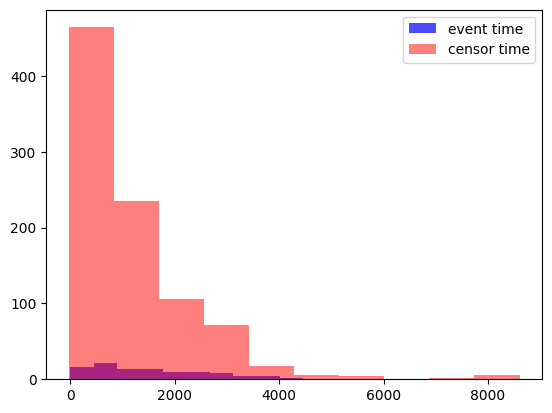

In [ ]:
deathtt = brca_df['days_to_death'][~np.isnan(brca_df['days_to_death'])]
censortt = brca_df['days_to_last_followup'][~np.isnan(brca_df['days_to_last_followup'])]
print("Number of events: %d" % len(deathtt))
print("Number of censored cases: %d" %len(censortt))
plt.hist(deathtt, color='b', label='event time', alpha=0.7)
plt.hist(censortt, color='r', label='censor time', alpha=0.5)
plt.legend()
plt.show()

In [ ]:
# get censoring status and survival time
brca_df['status'] = [int(i) for i in ~np.isnan(brca_df['days_to_death'])]

brca_df['time'] = brca_df['days_to_death']
brca_df['time'][np.isnan(brca_df['time'])] = brca_df['days_to_last_followup'][np.isnan(brca_df['time'])]

/tmp/ipykernel_777201/4163331497.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  brca_df['time'][np.isnan(brca_df['time'])] = brca_df['days_to_last_followup'][np.isnan(brca_df['time'])]


In [ ]:
brca_df = brca_df.drop(columns=['days_to_death',"days_to_last_followup"])
brca_df = brca_df.dropna().reset_index(drop=True)

In [ ]:
print("Event rate in the TCGA BRCA data: %f" % (sum(brca_df['status']) / brca_df.shape[0]))

Event rate in the TCGA BRCA data: 0.100592


In [ ]:
learning_rate = 1e-4
parameters = {
    'num_nodes': [64, 32, 32],
    'out_features': 1,
    'batch_norm' :True,
    'dropout' : 0.2,
    'output_bias' : True
}

In [ ]:
train_df, test_df = train_test_split(brca_df, test_size=0.2, random_state=42, stratify=brca_df['status'])

subset = [train_df.shape[0]]
ds = DeepSurvPipeline(train_df=train_df, test_df=test_df, dataName="tcga-brca")
ds_results = ds.run_deepsurv(subset,
                            batch_sizes=[32],
                            patience=25, min_delta=1e-3,
                            kwargs=parameters, verbose=True, print_scores=False)
ds_results

0:	[0s / 0s],	
1:	[0s / 0s],	
2:	[0s / 0s],	
3:	[0s / 0s],	
4:	[0s / 0s],	
5:	[0s / 0s],	
6:	[0s / 0s],	
7:	[0s / 0s],	
8:	[0s / 0s],	
9:	[0s / 0s],	
10:	[0s / 0s],	
11:	[0s / 0s],	
12:	[0s / 0s],	
13:	[0s / 0s],	
14:	[0s / 0s],	
15:	[0s / 1s],	
16:	[0s / 1s],	
17:	[0s / 1s],	
18:	[0s / 1s],	
19:	[0s / 1s],	
20:	[0s / 1s],	
21:	[0s / 1s],	
22:	[0s / 1s],	
23:	[0s / 1s],	
24:	[0s / 1s],	


/home/nfs/dengy/dl-env/lib/python3.8/site-packages/torchtuples/base.py:669: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.net.load_state_dict(torch.load(path, **kwargs)

,n train,train time,train score,test score
0,811,1.68,0.437989,0.51035


## Simulated data with batch

In [20]:
# load simulated data
df_withBatch = pd.read_csv(os.path.join("data","batch", "demo_sim_withBatch.csv")).iloc[:, 1:]
df_noBatch   = pd.read_csv(os.path.join("data","batch", "demo_sim_noBatch.csv")).iloc[:, 1:]

df_withBatch.head()

,t,delta,A_25_P00010019,A_25_P00010020,A_25_P00010021,A_25_P00010023,A_25_P00010041,A_25_P00010042,A_25_P00010043,A_25_P00010044,...,A_25_P00016269,A_25_P00016270,A_25_P00016271,A_38_P00018874,A_38_P00018875,A_38_P00018876,A_38_P00018877,A_38_P00018878,A_38_P00018879,batch_id
0,54.77,0,5.414510,5.361662,5.310293,5.324175,5.303017,5.280794,5.155670,5.133808,...,5.464329,5.540626,5.496476,5.476537,5.370435,5.593264,5.664620,5.554928,5.877363,1
1,9.63,1,5.645660,5.628909,5.428349,5.476566,5.651610,5.433626,5.502592,5.512356,...,6.003386,6.206899,6.001569,5.825270,5.861964,6.057292,6.187139,6.776756,7.332764,1
2,35.93,0,5.556705,5.498588,5.415355,5.568460,5.446503,5.393021,5.474867,5.342807,...,5.669618,5.745632,5.669056,5.699790,5.704279,5.976060,5.899931,6.011728,6.423470,1
3,71.84,0,5.107029,4.998545,5.001954,4.976329,5.009803,4.983482,4.873145,4.878836,...,5.203232,5.211459,5.179419,4.940771,4.868911,5.083392,5.119356,5.026625,5.225131,1
4,20.52,1,5.715634,5.554129,5.560682,5.429897,5.525073,5.539028,5.455037,5.461786,...,6.043570,6.009590,6.041434,5.494935,5.562034,5.585995,5.702457,5.546448,5.863067,1


In [ ]:
train_df, test_df = train_test_split(df_withBatch, test_size=0.2, random_state=42, stratify=df_withBatch['delta'])

# subset = [train_df.shape[0]]
# ds = DeepSurvPipeline(train_df=train_df, test_df=test_df, dataName="with-batch")
# ds_results = ds.run_deepsurv(subset, time_col='t', status_col='delta',
#                             batch_sizes=[8],
#                             patience=25, min_delta=1e-2, 
#                             kwargs=parameters, verbose=False, print_scores=True)
# ds_results

NameError: name 'df_withBatch' is not defined

In [ ]:
train_df, test_df = train_test_split(df_noBatch, test_size=0.2, random_state=42, stratify=df_noBatch['delta'])

subset = [train_df.shape[0]]
ds = DeepSurvPipeline(train_df=train_df, test_df=test_df, dataName="with-batch")
ds_results = ds.run_deepsurv(subset, time_col='t', status_col='delta',
                            batch_sizes=[8],
                            patience=25, min_delta=1e-2, 
                            kwargs=parameters, verbose=True, print_scores=True)

0:	[0s / 0s],		train_loss: 1.4430,	val_loss: 2.2770
1:	[0s / 0s],		train_loss: 1.2151,	val_loss: 1.8226
2:	[0s / 0s],		train_loss: 1.1575,	val_loss: 1.6374
3:	[0s / 0s],		train_loss: 1.1089,	val_loss: 1.5421
4:	[0s / 0s],		train_loss: 1.1016,	val_loss: 1.4289
5:	[0s / 0s],		train_loss: 1.0703,	val_loss: 1.3313
6:	[0s / 0s],		train_loss: 1.0573,	val_loss: 1.3368
7:	[0s / 0s],		train_loss: 1.0322,	val_loss: 1.3628
8:	[0s / 0s],		train_loss: 1.0965,	val_loss: 1.1529
9:	[0s / 0s],		train_loss: 0.9755,	val_loss: 1.1564
10:	[0s / 0s],		train_loss: 1.0619,	val_loss: 1.2399
11:	[0s / 0s],		train_loss: 0.9085,	val_loss: 1.2943
12:	[0s / 0s],		train_loss: 0.9006,	val_loss: 1.3940
13:	[0s / 0s],		train_loss: 0.8678,	val_loss: 1.2190
14:	[0s / 0s],		train_loss: 0.8291,	val_loss: 1.1011
15:	[0s / 0s],		train_loss: 0.9967,	val_loss: 1.1122
16:	[0s / 0s],		train_loss: 0.8468,	val_loss: 1.2879
17:	[0s / 0s],		train_loss: 0.8151,	val_loss: 1.4811
18:	[0s / 0s],		train_loss: 0.9106,	val_loss: 1.2335
19:

/home/nfs/dengy/dl-env/lib/python3.8/site-packages/torchtuples/base.py:669: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.net.load_state_dict(torch.load(path, **kwargs)

# Train on Simulation Data

In [14]:
status_col='status'
time_col = "time"

### Linear: Moderate

In [13]:
## Parameter setup
# Load data
folder = 'linear'
keywords = ['moderate', "latest", 'RW']
DATANAME = 'linear-moderate'
train_df, test_df = load_simulate_survival_data(folder=folder, keywords=keywords, test_size=0.1)

print(f"Training data dimensions: {train_df.shape}")
print(f"Testing data dimensions:  {test_df.shape}")

Training data dimensions: (18000, 1035)
Testing data dimensions:  (2000, 1035)


In [16]:
subset = [50, 500, 1000, 2000, 5000]
batch_sizes =[8, 16, 16, 32, 64]
runs = [20,20,10,10,5]
hyperparams = {
    "learning_rate": {"type": "float", "low": 1e-4, "high": 1e-2, "log": True},
    # "num_nodes": {"type": "categorical", "choices": [[32,32], [16,16]]},
    "dropout": {"type": "categorical", "choices": [0.1, 0.5]},
    # "batch_size": {'type': "categorical", "choices": [32,64,128]}
}

In [17]:
best_params_ls, n_train, model_time, train_scores, test_scores = [],[],[],[],[]

for (n, batch_size, n_run) in zip(subset, batch_sizes, runs): 
    
    run_train_scores, run_test_scores, run_time = [],[],[]
    for run in range(n_run+1):
        if n < train_df.shape[0]:
            train_sub,_ = train_test_split(train_df,
                                        train_size=n/train_df.shape[0], 
                                        shuffle=True, random_state=run,
                                        stratify=train_df[status_col])
        else:
            train_sub = train_df
        
        ds = DeepSurvPipeline(train_sub, test_df, hyperparameters=hyperparams, dataName=DATANAME)
        if run == 0:
            study = ds.tune_hyperparameters(train_sub, n_trials=15, n_jobs=16)
            best_params = study.best_params
            continue
        duration, train_c, test_c = ds.train_with_best_params(params=best_params, verbose=False, print_scores=False)
        
        n_train.append(n)
        model_time.append(duration)
        train_scores.append(train_c)
        test_scores.append(test_c)
        best_params_ls.append(best_params)
        
        run_train_scores.append(train_c)
        run_test_scores.append(test_c)
        run_time.append(duration)
    
    print(f"N={n} Training time ({np.mean(run_time)}s): Train C-Index: {round(np.mean(run_train_scores),3)} | Test C-index: {round(np.mean(run_test_scores),3)} (Mean)")                


[I 2025-01-07 16:55:05,755] A new study created in RDB with name: linear-moderate-50
[I 2025-01-07 16:58:21,155] Trial 12 finished with value: 0.6597684517225162 and parameters: {'learning_rate': 0.004014731207287871, 'dropout': 0.5}. Best is trial 12 with value: 0.6597684517225162.
[I 2025-01-07 16:58:30,881] Trial 6 finished with value: 0.705691086938837 and parameters: {'learning_rate': 0.0026546611830762187, 'dropout': 0.5}. Best is trial 6 with value: 0.705691086938837.
[I 2025-01-07 16:58:31,475] Trial 13 finished with value: 0.5797497723914312 and parameters: {'learning_rate': 0.000194718270195271, 'dropout': 0.1}. Best is trial 6 with value: 0.705691086938837.
[I 2025-01-07 16:58:31,654] Trial 0 finished with value: 0.5393251503338623 and parameters: {'learning_rate': 0.0001301035200430944, 'dropout': 0.5}. Best is trial 6 with value: 0.705691086938837.
[I 2025-01-07 16:58:32,511] Trial 4 finished with value: 0.49468918534366013 and parameters: {'learning_rate': 0.0001433123360

Best trial parameters: {'learning_rate': 0.0026546611830762187, 'dropout': 0.5}


[I 2025-01-07 16:59:43,701] A new study created in RDB with name: linear-moderate-500


N=50 Training time (0.2375s): Train C-Index: 0.789 | Test C-index: 0.61 (Mean)


[I 2025-01-07 17:02:45,740] Trial 8 finished with value: 0.7807337521066222 and parameters: {'learning_rate': 0.0028418050739308673, 'dropout': 0.1}. Best is trial 8 with value: 0.7807337521066222.
[I 2025-01-07 17:03:02,719] Trial 5 finished with value: 0.7909293135773565 and parameters: {'learning_rate': 0.0018850874343691712, 'dropout': 0.1}. Best is trial 5 with value: 0.7909293135773565.
[I 2025-01-07 17:03:21,979] Trial 9 finished with value: 0.7926057798315662 and parameters: {'learning_rate': 0.0010743659843153533, 'dropout': 0.1}. Best is trial 9 with value: 0.7926057798315662.
[I 2025-01-07 17:03:25,427] Trial 10 finished with value: 0.7994840508189205 and parameters: {'learning_rate': 0.0017075104422977479, 'dropout': 0.1}. Best is trial 10 with value: 0.7994840508189205.
[I 2025-01-07 17:03:29,081] Trial 4 finished with value: 0.7794749521745045 and parameters: {'learning_rate': 0.0006818761506251239, 'dropout': 0.1}. Best is trial 10 with value: 0.7994840508189205.
[I 2025

Best trial parameters: {'learning_rate': 0.0008244158673895692, 'dropout': 0.5}


[I 2025-01-07 17:05:54,673] Using an existing study with name 'linear-moderate-1000' instead of creating a new one.


N=500 Training time (1.8809999999999996s): Train C-Index: 0.882 | Test C-index: 0.774 (Mean)


[I 2025-01-07 17:10:24,350] Trial 40 finished with value: 0.8062546454077794 and parameters: {'learning_rate': 0.004228427982293931, 'dropout': 0.1}. Best is trial 5 with value: 0.8131435667926394.
[I 2025-01-07 17:10:36,481] Trial 37 finished with value: 0.7997613924912255 and parameters: {'learning_rate': 0.004791503868503723, 'dropout': 0.1}. Best is trial 5 with value: 0.8131435667926394.
[I 2025-01-07 17:11:01,191] Trial 41 finished with value: 0.8018266029459069 and parameters: {'learning_rate': 0.004510775580388289, 'dropout': 0.1}. Best is trial 5 with value: 0.8131435667926394.
[I 2025-01-07 17:11:18,986] Trial 38 finished with value: 0.8032147687172598 and parameters: {'learning_rate': 0.003898202531046584, 'dropout': 0.1}. Best is trial 5 with value: 0.8131435667926394.
[I 2025-01-07 17:11:24,095] Trial 32 finished with value: 0.8004345516212273 and parameters: {'learning_rate': 0.004531611231460206, 'dropout': 0.1}. Best is trial 5 with value: 0.8131435667926394.
[I 2025-01

Best trial parameters: {'learning_rate': 0.0007641732585905166}


[I 2025-01-07 17:13:23,689] Using an existing study with name 'linear-moderate-2000' instead of creating a new one.


N=1000 Training time (3.4379999999999997s): Train C-Index: 0.872 | Test C-index: 0.79 (Mean)


[I 2025-01-07 17:21:04,038] Trial 32 finished with value: 0.8078967252200584 and parameters: {'learning_rate': 0.0015315098916342965, 'dropout': 0.1}. Best is trial 8 with value: 0.8140903684040733.
[I 2025-01-07 17:21:24,793] Trial 19 finished with value: 0.8111586613568449 and parameters: {'learning_rate': 0.0014353357710198095, 'dropout': 0.1}. Best is trial 8 with value: 0.8140903684040733.
[I 2025-01-07 17:21:25,984] Trial 30 finished with value: 0.8045751378878535 and parameters: {'learning_rate': 0.0006455938478845993, 'dropout': 0.1}. Best is trial 8 with value: 0.8140903684040733.
[I 2025-01-07 17:21:26,983] Trial 22 finished with value: 0.8043397016678435 and parameters: {'learning_rate': 0.0006140472895904695, 'dropout': 0.1}. Best is trial 8 with value: 0.8140903684040733.
[I 2025-01-07 17:21:30,012] Trial 25 finished with value: 0.8019157011576267 and parameters: {'learning_rate': 0.0006906707248437058, 'dropout': 0.1}. Best is trial 8 with value: 0.8140903684040733.
[I 20

Best trial parameters: {'learning_rate': 0.0011600637818254633}


[I 2025-01-07 17:25:05,385] Using an existing study with name 'linear-moderate-5000' instead of creating a new one.


N=2000 Training time (5.671s): Train C-Index: 0.852 | Test C-index: 0.803 (Mean)


[I 2025-01-07 17:38:43,889] Trial 20 finished with value: 0.8088291606509816 and parameters: {'learning_rate': 0.0025065611224212208, 'dropout': 0.1}. Best is trial 4 with value: 0.8148163147073626.
[I 2025-01-07 17:39:13,365] Trial 13 finished with value: 0.8095005309384973 and parameters: {'learning_rate': 0.002762043830169803, 'dropout': 0.1}. Best is trial 4 with value: 0.8148163147073626.
[I 2025-01-07 17:40:14,333] Trial 21 finished with value: 0.8120118260779581 and parameters: {'learning_rate': 0.0020434670021805177, 'dropout': 0.1}. Best is trial 4 with value: 0.8148163147073626.
[I 2025-01-07 17:40:53,252] Trial 16 finished with value: 0.8082720156102988 and parameters: {'learning_rate': 0.0023752433589418827, 'dropout': 0.5}. Best is trial 4 with value: 0.8148163147073626.
[I 2025-01-07 17:40:55,689] Trial 10 finished with value: 0.8117096872092645 and parameters: {'learning_rate': 0.0016083435458083227, 'dropout': 0.1}. Best is trial 4 with value: 0.8148163147073626.
[I 202

Best trial parameters: {'learning_rate': 0.00036212251189812105}
N=5000 Training time (15.190000000000001s): Train C-Index: 0.842 | Test C-index: 0.814 (Mean)


## Linear: Weak

Event rate in train set: 0.750333
Event rate in test set: 0.750500
Survival time distribution:


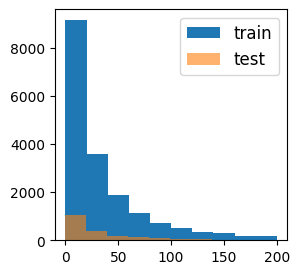

In [29]:
# prepare data
folder = 'linear'
keywords = ['weak', "latest", '20000']
DATANAME = 'linear-weak'
# train_df, val_df, test_df = load_simulate_survival_data(folder=folder, keywords=keywords, val_split=True)
train_df, test_df = load_simulate_survival_data(folder=folder, keywords=keywords, test_size=0.1)

# observe data
print("Event rate in train set: %f" % (sum(train_df['status']==1) / train_df.shape[0]))
print("Event rate in test set: %f" %  (sum(test_df['status']==1) / test_df.shape[0]))
print('Survival time distribution:')
_, ax = plt.subplots(figsize=(3,3))
ax.hist(train_df['time'], label='train')
# ax.hist(val_df['time'],   label='val', alpha=.8)
ax.hist(test_df['time'], label='test', alpha=0.6)
ax.legend(fontsize=12)
plt.show()

In [30]:
subset = [50,500,1000, 2000,5000]
batch_sizes =[8, 16, 16, 32, 64]
runs = [10,10,10,10,10]
hyperparams = {
    "learning_rate": {"type": "float", "low": 1e-4, "high": 1e-2, "log": True},
    # "num_nodes": {"type": "categorical", "choices": [[32,32], [16,16]]},
    "dropout": {"type": "categorical", "choices": [0.1,0.5]},
    # "batch_size": {'type': "categorical", "choices": [32,64,128]}
}

In [31]:
best_params_ls, n_train, model_time, train_scores, test_scores = [],[],[],[],[]

for (n, batch_size, n_run) in zip(subset, batch_sizes, runs): 
    
    run_train_scores, run_test_scores, run_time = [],[],[]
    for run in range(n_run+1):
        if n < train_df.shape[0]:
            train_sub,_ = train_test_split(train_df,
                                        train_size=n/train_df.shape[0], 
                                        shuffle=True, random_state=run,
                                        stratify=train_df[status_col])
        else:
            train_sub = train_df
        
        ds = DeepSurvPipeline(train_sub, test_df, hyperparameters=hyperparams, dataName=DATANAME)
        if run == 0:
            study = ds.tune_hyperparameters(train_sub, n_trials=15, n_jobs=16)
            best_params = study.best_params
            best_params_ls.append(best_params)
            continue
        duration, train_c, test_c = ds.train_with_best_params(params=best_params, verbose=False, print_scores=False)
        
        n_train.append(n)
        model_time.append(duration)
        train_scores.append(train_c)
        test_scores.append(test_c)
            
        run_train_scores.append(train_c)
        run_test_scores.append(test_c)
        run_time.append(duration)
    
    print(f"N={n} Training time ({np.mean(run_time)}s): Train C-Index: {round(np.mean(run_train_scores),3)} | Test C-index: {round(np.mean(run_test_scores),3)} (Mean)")                

# ============== Save results ===============
model_results = pd.DataFrame({
    'n train': n_train, 
    'train time':model_time,
    'train score':train_scores, 
    'test score':test_scores}
)

[I 2024-12-19 13:39:06,780] A new study created in RDB with name: linear-weak-50
[I 2024-12-19 13:42:19,865] Trial 2 finished with value: 0.5709425631839424 and parameters: {'learning_rate': 0.0001736726273715398, 'dropout': 0.5}. Best is trial 2 with value: 0.5709425631839424.
[I 2024-12-19 13:42:25,851] Trial 8 finished with value: 0.5075163342404722 and parameters: {'learning_rate': 0.000394379427207373, 'dropout': 0.1}. Best is trial 2 with value: 0.5709425631839424.
[I 2024-12-19 13:42:33,208] Trial 6 finished with value: 0.5848225912019015 and parameters: {'learning_rate': 0.0033361936894263314, 'dropout': 0.1}. Best is trial 6 with value: 0.5848225912019015.
[I 2024-12-19 13:42:33,327] Trial 4 finished with value: 0.6891083054876159 and parameters: {'learning_rate': 0.0011164339757238563, 'dropout': 0.1}. Best is trial 4 with value: 0.6891083054876159.
[I 2024-12-19 13:42:34,975] Trial 1 finished with value: 0.5643491565905359 and parameters: {'learning_rate': 0.0003126828734264

Best trial parameters: {'learning_rate': 0.003000504349779096, 'dropout': 0.1}


[I 2024-12-19 13:43:12,476] A new study created in RDB with name: linear-weak-500


N=50 Training time (0.164s): Train C-Index: 0.757 | Test C-index: 0.528 (Mean)


[I 2024-12-19 13:46:16,315] Trial 6 finished with value: 0.6202960287310872 and parameters: {'learning_rate': 0.0027708892195662652, 'dropout': 0.1}. Best is trial 6 with value: 0.6202960287310872.
[I 2024-12-19 13:46:20,695] Trial 7 finished with value: 0.609006332548231 and parameters: {'learning_rate': 0.001155760320497242, 'dropout': 0.1}. Best is trial 6 with value: 0.6202960287310872.
[I 2024-12-19 13:46:28,681] Trial 12 finished with value: 0.6329414058423761 and parameters: {'learning_rate': 0.003900276255359308, 'dropout': 0.1}. Best is trial 12 with value: 0.6329414058423761.
[I 2024-12-19 13:46:33,544] Trial 1 finished with value: 0.5859278039345754 and parameters: {'learning_rate': 0.0004046185899388891, 'dropout': 0.1}. Best is trial 12 with value: 0.6329414058423761.
[I 2024-12-19 13:46:40,954] Trial 0 finished with value: 0.5754724633145752 and parameters: {'learning_rate': 0.0002736996742796856, 'dropout': 0.1}. Best is trial 12 with value: 0.6329414058423761.
[I 2024-1

Best trial parameters: {'learning_rate': 0.004853164341959896, 'dropout': 0.5}


[I 2024-12-19 13:47:57,394] A new study created in RDB with name: linear-weak-1000


N=500 Training time (1.206s): Train C-Index: 0.773 | Test C-index: 0.648 (Mean)


[I 2024-12-19 13:52:28,055] Trial 9 finished with value: 0.664194623272976 and parameters: {'learning_rate': 0.00144567954633041, 'dropout': 0.1}. Best is trial 9 with value: 0.664194623272976.
[I 2024-12-19 13:52:35,642] Trial 5 finished with value: 0.6790018673176454 and parameters: {'learning_rate': 0.0018830862423128002, 'dropout': 0.1}. Best is trial 5 with value: 0.6790018673176454.
[I 2024-12-19 13:52:45,845] Trial 12 finished with value: 0.6658042556680086 and parameters: {'learning_rate': 0.0009809859186989827, 'dropout': 0.1}. Best is trial 5 with value: 0.6790018673176454.
[I 2024-12-19 13:52:57,005] Trial 10 finished with value: 0.6692508510321595 and parameters: {'learning_rate': 0.0006848671313275324, 'dropout': 0.1}. Best is trial 5 with value: 0.6790018673176454.
[I 2024-12-19 13:53:07,023] Trial 14 finished with value: 0.6743702453089101 and parameters: {'learning_rate': 0.008689497584497559, 'dropout': 0.1}. Best is trial 5 with value: 0.6790018673176454.
[I 2024-12-1

Best trial parameters: {'learning_rate': 0.0009174678091085844, 'dropout': 0.5}


[I 2024-12-19 13:55:37,465] A new study created in RDB with name: linear-weak-2000


N=1000 Training time (2.7159999999999997s): Train C-Index: 0.784 | Test C-index: 0.667 (Mean)


[I 2024-12-19 14:02:48,327] Trial 9 finished with value: 0.6877153508484285 and parameters: {'learning_rate': 0.00499257746929855, 'dropout': 0.1}. Best is trial 9 with value: 0.6877153508484285.
[I 2024-12-19 14:02:50,264] Trial 12 finished with value: 0.6903910019419387 and parameters: {'learning_rate': 0.0006174942374684412, 'dropout': 0.1}. Best is trial 12 with value: 0.6903910019419387.
[I 2024-12-19 14:03:07,976] Trial 3 finished with value: 0.6807116926735821 and parameters: {'learning_rate': 0.005368397644866624, 'dropout': 0.5}. Best is trial 12 with value: 0.6903910019419387.
[I 2024-12-19 14:03:24,104] Trial 0 finished with value: 0.6850815094093996 and parameters: {'learning_rate': 0.006144138244668673, 'dropout': 0.1}. Best is trial 12 with value: 0.6903910019419387.
[I 2024-12-19 14:04:00,099] Trial 13 finished with value: 0.6873728534343222 and parameters: {'learning_rate': 0.0042128339532117726, 'dropout': 0.5}. Best is trial 12 with value: 0.6903910019419387.
[I 2024-

Best trial parameters: {'learning_rate': 0.0018096840486263746, 'dropout': 0.5}


[I 2024-12-19 14:07:46,646] A new study created in RDB with name: linear-weak-5000


N=2000 Training time (5.773000000000001s): Train C-Index: 0.764 | Test C-index: 0.685 (Mean)


[I 2024-12-19 14:20:08,721] Trial 9 finished with value: 0.6779651478128734 and parameters: {'learning_rate': 0.006905318282056183, 'dropout': 0.5}. Best is trial 9 with value: 0.6779651478128734.
[I 2024-12-19 14:21:09,451] Trial 3 finished with value: 0.6720365036810054 and parameters: {'learning_rate': 0.009272237946647034, 'dropout': 0.5}. Best is trial 9 with value: 0.6779651478128734.
[I 2024-12-19 14:22:48,447] Trial 14 finished with value: 0.6955547235673682 and parameters: {'learning_rate': 0.006265641829045784, 'dropout': 0.1}. Best is trial 14 with value: 0.6955547235673682.
[I 2024-12-19 14:23:26,410] Trial 12 finished with value: 0.6847508698682673 and parameters: {'learning_rate': 0.006308917852564534, 'dropout': 0.5}. Best is trial 14 with value: 0.6955547235673682.
[I 2024-12-19 14:23:40,988] Trial 13 finished with value: 0.7089572566059041 and parameters: {'learning_rate': 0.0007334095533844638, 'dropout': 0.1}. Best is trial 13 with value: 0.7089572566059041.
[I 2024-

Best trial parameters: {'learning_rate': 0.0002803110737743245, 'dropout': 0.5}
N=5000 Training time (15.019s): Train C-Index: 0.758 | Test C-index: 0.701 (Mean)


In [33]:
ds.write(model_results=model_results, fileName="model.results.10runs.txt")

## Nonlinear: Quadratic

Event rate in train set: 0.746222
Event rate in test set: 0.746000
Survival time distribution:


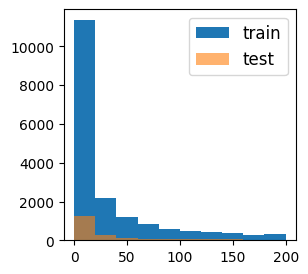

In [4]:
# prepare data
folder = 'nonlinear'
keywords = ['quadratic', "latest", '20000']
DATANAME = 'nl-quadratic'
# train_df, val_df, test_df = load_simulate_survival_data(folder=folder, keywords=keywords, val_split=True)
train_df, test_df = load_simulate_survival_data(folder=folder, keywords=keywords, test_size=0.1)
plot_simulation_data(train_df, test_df)

In [6]:
subset = [50, 500, 1000, 2000, 5000]
batch_sizes =[8, 16, 16, 32, 64]
runs = [20,20,10,10,10]
hyperparams = {
    "learning_rate": {"type": "float", "low": 1e-4, "high": 1e-2, "log": True},
    "num_nodes": {"type": "categorical", "choices": [[32,32], [16,16]]},
    "dropout": {"type": "categorical", "choices": [0.1,0.5]},
    # "batch_size": {'type': "categorical", "choices": [32,64,128]}
}

In [12]:
best_params_ls, n_train, model_time, train_scores, test_scores = [],[],[],[],[]

for (n, batch_size, n_run) in zip(subset, batch_sizes, runs): 
    
    run_train_scores, run_test_scores, run_time = [],[],[]
    for run in range(n_run+1):
        if n < train_df.shape[0]:
            train_sub,_ = train_test_split(train_df,
                                        train_size=n/train_df.shape[0], 
                                        shuffle=True, random_state=run,
                                        stratify=train_df[status_col])
        else:
            train_sub = train_df
        
        ds = DeepSurvPipeline(train_sub, test_df, hyperparameters=hyperparams, dataName=DATANAME)
        if run == 0:
            study = ds.tune_hyperparameters(train_sub, n_trials=20, n_jobs=16)
            best_params = study.best_params
            best_params_ls.append(best_params)
            continue
        duration, train_c, test_c = ds.train_with_best_params(params=best_params, verbose=False, print_scores=False)
        
        n_train.append(n)
        model_time.append(duration)
        train_scores.append(train_c)
        test_scores.append(test_c)
            
        run_train_scores.append(train_c)
        run_test_scores.append(test_c)
        run_time.append(duration)
    
    print(f"N={n} Training time ({np.mean(run_time)}s): Train C-Index: {round(np.mean(run_train_scores),3)} | Test C-index: {round(np.mean(run_test_scores),3)} (Mean)")                

# ============== Save results ===============
model_results = pd.DataFrame({
    'n train': n_train, 
    'train time':model_time,
    'train score':train_scores, 
    'test score':test_scores}
)

[I 2025-01-06 11:17:06,902] Using an existing study with name 'nl-quadratic-50' instead of creating a new one.
[I 2025-01-06 11:21:30,648] Trial 49 finished with value: 0.6869830659536542 and parameters: {'learning_rate': 0.00510971837679028, 'num_nodes': [32, 32], 'dropout': 0.1}. Best is trial 25 with value: 0.7420874713521772.
[I 2025-01-06 11:21:40,503] Trial 36 finished with value: 0.6496836007130125 and parameters: {'learning_rate': 0.005247316158886313, 'num_nodes': [16, 16], 'dropout': 0.1}. Best is trial 25 with value: 0.7420874713521772.
[I 2025-01-06 11:21:40,530] Trial 41 finished with value: 0.6635847975553857 and parameters: {'learning_rate': 0.00500918802141851, 'num_nodes': [32, 32], 'dropout': 0.1}. Best is trial 25 with value: 0.7420874713521772.
[I 2025-01-06 11:21:46,122] Trial 50 finished with value: 0.6195588235294117 and parameters: {'learning_rate': 0.005792686174354546, 'num_nodes': [16, 16], 'dropout': 0.1}. Best is trial 25 with value: 0.7420874713521772.
[I 

Best trial parameters: {'learning_rate': 0.0015890814833935034, 'dropout': 0.1}


[I 2025-01-06 11:23:22,742] Using an existing study with name 'nl-quadratic-500' instead of creating a new one.


N=50 Training time (0.21399999999999997s): Train C-Index: 0.834 | Test C-index: 0.546 (Mean)


[I 2025-01-06 11:27:17,625] Trial 47 finished with value: 0.6657045936779126 and parameters: {'learning_rate': 0.004101402436319301, 'num_nodes': [32, 32], 'dropout': 0.1}. Best is trial 32 with value: 0.6949629383750308.
[I 2025-01-06 11:27:34,757] Trial 41 finished with value: 0.662133031119079 and parameters: {'learning_rate': 0.004431160815456842, 'num_nodes': [16, 16], 'dropout': 0.1}. Best is trial 32 with value: 0.6949629383750308.
[I 2025-01-06 11:27:47,663] Trial 37 finished with value: 0.6670842057211886 and parameters: {'learning_rate': 0.003790095810549351, 'num_nodes': [32, 32], 'dropout': 0.1}. Best is trial 32 with value: 0.6949629383750308.
[I 2025-01-06 11:27:50,120] Trial 45 finished with value: 0.7035422519361789 and parameters: {'learning_rate': 0.004437688519422004, 'num_nodes': [32, 32], 'dropout': 0.1}. Best is trial 45 with value: 0.7035422519361789.
[I 2025-01-06 11:27:52,155] Trial 44 finished with value: 0.6691903309325513 and parameters: {'learning_rate': 0.

Best trial parameters: {'learning_rate': 0.004437688519422004, 'num_nodes': [32, 32], 'dropout': 0.1}


[I 2025-01-06 11:29:40,682] Using an existing study with name 'nl-quadratic-1000' instead of creating a new one.


N=500 Training time (0.8700000000000001s): Train C-Index: 0.818 | Test C-index: 0.66 (Mean)


[I 2025-01-06 11:36:41,087] Trial 45 finished with value: 0.6891911346657277 and parameters: {'learning_rate': 0.0029449732501657727, 'num_nodes': [16, 16], 'dropout': 0.5}. Best is trial 7 with value: 0.7443072880179173.
[I 2025-01-06 11:37:02,776] Trial 50 finished with value: 0.6922109962536334 and parameters: {'learning_rate': 0.0028615207471592813, 'num_nodes': [16, 16], 'dropout': 0.5}. Best is trial 7 with value: 0.7443072880179173.
[I 2025-01-06 11:37:03,223] Trial 39 finished with value: 0.6929203856198626 and parameters: {'learning_rate': 0.002777538060315972, 'num_nodes': [32, 32], 'dropout': 0.5}. Best is trial 7 with value: 0.7443072880179173.
[I 2025-01-06 11:37:21,834] Trial 40 finished with value: 0.7059605493833041 and parameters: {'learning_rate': 0.0027825489260210764, 'num_nodes': [32, 32], 'dropout': 0.5}. Best is trial 7 with value: 0.7443072880179173.
[I 2025-01-06 11:37:23,032] Trial 42 finished with value: 0.7086813955140994 and parameters: {'learning_rate': 0.

Best trial parameters: {'learning_rate': 0.005240711451605818, 'dropout': 0.1}


[I 2025-01-06 11:39:39,014] Using an existing study with name 'nl-quadratic-2000' instead of creating a new one.


N=1000 Training time (2.6710000000000003s): Train C-Index: 0.864 | Test C-index: 0.729 (Mean)


[I 2025-01-06 11:49:12,240] Trial 45 finished with value: 0.7721719451727246 and parameters: {'learning_rate': 0.001401485955502852, 'num_nodes': [32, 32], 'dropout': 0.1}. Best is trial 13 with value: 0.7775780265860612.
[I 2025-01-06 11:49:16,704] Trial 37 finished with value: 0.7660454756170022 and parameters: {'learning_rate': 0.0014510601349400486, 'num_nodes': [16, 16], 'dropout': 0.1}. Best is trial 13 with value: 0.7775780265860612.
[I 2025-01-06 11:49:25,588] Trial 50 finished with value: 0.7659627475934551 and parameters: {'learning_rate': 0.001451908203009275, 'num_nodes': [16, 16], 'dropout': 0.1}. Best is trial 13 with value: 0.7775780265860612.
[I 2025-01-06 11:49:35,246] Trial 41 finished with value: 0.7737658729648087 and parameters: {'learning_rate': 0.0015916664431855345, 'num_nodes': [32, 32], 'dropout': 0.1}. Best is trial 13 with value: 0.7775780265860612.
[I 2025-01-06 11:49:54,211] Trial 42 finished with value: 0.7659228777881715 and parameters: {'learning_rate':

Best trial parameters: {'learning_rate': 0.0014286264369105714, 'dropout': 0.1}


[I 2025-01-06 11:53:32,963] Using an existing study with name 'nl-quadratic-5000' instead of creating a new one.


N=2000 Training time (4.372s): Train C-Index: 0.875 | Test C-index: 0.769 (Mean)


[I 2025-01-06 12:12:09,988] Trial 36 finished with value: 0.7381948479755905 and parameters: {'learning_rate': 0.008019098669824198, 'num_nodes': [32, 32], 'dropout': 0.1}. Best is trial 23 with value: 0.812919646825663.
[I 2025-01-06 12:12:18,331] Trial 46 finished with value: 0.7371333498093577 and parameters: {'learning_rate': 0.008426891540312799, 'num_nodes': [16, 16], 'dropout': 0.1}. Best is trial 23 with value: 0.812919646825663.
[I 2025-01-06 12:13:54,060] Trial 38 finished with value: 0.7470617595982563 and parameters: {'learning_rate': 0.008195324747797278, 'num_nodes': [32, 32], 'dropout': 0.1}. Best is trial 23 with value: 0.812919646825663.
[I 2025-01-06 12:14:03,173] Trial 49 finished with value: 0.7646283349882015 and parameters: {'learning_rate': 0.007384805805329934, 'num_nodes': [32, 32], 'dropout': 0.1}. Best is trial 23 with value: 0.812919646825663.
[I 2025-01-06 12:14:30,478] Trial 40 finished with value: 0.75720721287098 and parameters: {'learning_rate': 0.00704

Best trial parameters: {'learning_rate': 0.0006976857427331728, 'num_nodes': [16, 16], 'dropout': 0.1}
N=5000 Training time (14.021s): Train C-Index: 0.883 | Test C-index: 0.818 (Mean)


In [13]:
model_results

,n train,train time,train score,test score
0,50,0.22,0.879185,0.531668
1,50,0.13,0.637119,0.487477
2,50,0.37,0.970464,0.553731
3,50,0.13,0.692086,0.505219
4,50,0.21,0.877941,0.566384
...,...,...,...,...
65,5000,14.51,0.882573,0.817137
66,5000,16.79,0.895345,0.818173
67,5000,15.18,0.890899,0.819656
68,5000,12.21,0.879755,0.813790


In [14]:
ds.write(model_results=model_results, fileName="model.results.10runs.txt")

## Nonlinear: Interaction

Event rate in train set: 0.750000
Event rate in test set: 0.750000
Survival time distribution:


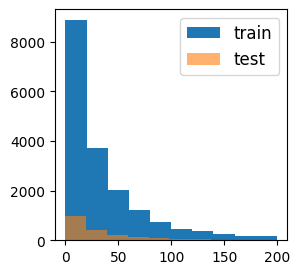

In [18]:
# prepare data
folder = 'nonlinear'
keywords = ['interaction', "latest", '20000']
DATANAME = 'nl-interaction'
# train_df, val_df, test_df = load_simulate_survival_data(folder=folder, keywords=keywords, val_split=True)
train_df, test_df = load_simulate_survival_data(folder=folder, keywords=keywords, test_size=0.1)
plot_simulation_data(train_df, test_df)

In [19]:
subset = [50, 500, 1000, 2000, 5000]
batch_sizes =[8, 16, 16, 32, 64]
runs = [20,20,10,10,10]
hyperparams = {
    "learning_rate": {"type": "float", "low": 1e-4, "high": 1e-2, "log": True},
    # "num_nodes": {"type": "categorical", "choices": [[32,32], [16,16]]},
    "dropout": {"type": "categorical", "choices": [0.1,0.5]},
    # "batch_size": {'type': "categorical", "choices": [32,64,128]}
}

In [20]:
best_params_ls, n_train, model_time, train_scores, test_scores = [],[],[],[],[]

for (n, batch_size, n_run) in zip(subset, batch_sizes, runs): 
    
    run_train_scores, run_test_scores, run_time = [],[],[]
    for run in range(n_run+1):
        if n < train_df.shape[0]:
            train_sub,_ = train_test_split(train_df,
                                        train_size=n/train_df.shape[0], 
                                        shuffle=True, random_state=run,
                                        stratify=train_df[status_col])
        else:
            train_sub = train_df
        
        ds = DeepSurvPipeline(train_sub, test_df, hyperparameters=hyperparams, dataName=DATANAME)
        if run == 0:
            study = ds.tune_hyperparameters(train_sub, n_trials=15, n_jobs=16)
            best_params = study.best_params
            best_params_ls.append(best_params)
            continue
        duration, train_c, test_c = ds.train_with_best_params(params=best_params, verbose=False, print_scores=False)
        
        n_train.append(n)
        model_time.append(duration)
        train_scores.append(train_c)
        test_scores.append(test_c)
            
        run_train_scores.append(train_c)
        run_test_scores.append(test_c)
        run_time.append(duration)
    
    print(f"N={n} Training time ({np.mean(run_time)}s): Train C-Index: {round(np.mean(run_train_scores),3)} | Test C-index: {round(np.mean(run_test_scores),3)} (Mean)")                

# ============== Save results ===============
model_results = pd.DataFrame({
    'n train': n_train, 
    'train time':model_time,
    'train score':train_scores, 
    'test score':test_scores}
)

[I 2025-01-06 12:41:33,645] A new study created in RDB with name: nl-interaction-50
[I 2025-01-06 12:44:30,721] Trial 11 finished with value: 0.6035442035442035 and parameters: {'learning_rate': 0.0010053860433327363, 'dropout': 0.5}. Best is trial 11 with value: 0.6035442035442035.
[I 2025-01-06 12:44:43,877] Trial 5 finished with value: 0.5816430716430716 and parameters: {'learning_rate': 0.0018706852875630911, 'dropout': 0.5}. Best is trial 11 with value: 0.6035442035442035.
[I 2025-01-06 12:44:44,090] Trial 4 finished with value: 0.6774048774048775 and parameters: {'learning_rate': 0.004595808312506594, 'dropout': 0.1}. Best is trial 4 with value: 0.6774048774048775.
[I 2025-01-06 12:44:50,274] Trial 10 finished with value: 0.505913935913936 and parameters: {'learning_rate': 0.00012650313139414877, 'dropout': 0.5}. Best is trial 4 with value: 0.6774048774048775.
[I 2025-01-06 12:44:50,351] Trial 13 finished with value: 0.5654634854634855 and parameters: {'learning_rate': 0.00122343

Best trial parameters: {'learning_rate': 0.002899663561690444, 'dropout': 0.5}


[I 2025-01-06 12:46:00,492] A new study created in RDB with name: nl-interaction-500


N=50 Training time (0.1905s): Train C-Index: 0.723 | Test C-index: 0.535 (Mean)


[I 2025-01-06 12:49:27,427] Trial 13 finished with value: 0.5887919974440237 and parameters: {'learning_rate': 0.0037822367614973734, 'dropout': 0.1}. Best is trial 13 with value: 0.5887919974440237.
[I 2025-01-06 12:49:35,214] Trial 0 finished with value: 0.611939831293077 and parameters: {'learning_rate': 0.0017009794008026196, 'dropout': 0.1}. Best is trial 0 with value: 0.611939831293077.
[I 2025-01-06 12:49:38,599] Trial 3 finished with value: 0.5925558743178149 and parameters: {'learning_rate': 0.0016029462321855963, 'dropout': 0.1}. Best is trial 0 with value: 0.611939831293077.
[I 2025-01-06 12:49:39,572] Trial 5 finished with value: 0.5966821456371871 and parameters: {'learning_rate': 0.0035979586486551427, 'dropout': 0.5}. Best is trial 0 with value: 0.611939831293077.
[I 2025-01-06 12:49:40,025] Trial 14 finished with value: 0.5912939648123667 and parameters: {'learning_rate': 0.0006235708704987642, 'dropout': 0.1}. Best is trial 0 with value: 0.611939831293077.
[I 2025-01-0

Best trial parameters: {'learning_rate': 0.0017009794008026196, 'dropout': 0.1}


[I 2025-01-06 12:51:04,858] A new study created in RDB with name: nl-interaction-1000


N=500 Training time (0.759s): Train C-Index: 0.746 | Test C-index: 0.59 (Mean)


[I 2025-01-06 12:55:34,831] Trial 4 finished with value: 0.6377974260788233 and parameters: {'learning_rate': 0.0019221075725515385, 'dropout': 0.1}. Best is trial 4 with value: 0.6377974260788233.
[I 2025-01-06 12:55:41,329] Trial 6 finished with value: 0.6381161179964566 and parameters: {'learning_rate': 0.004911919835967987, 'dropout': 0.1}. Best is trial 6 with value: 0.6381161179964566.
[I 2025-01-06 12:55:48,196] Trial 0 finished with value: 0.6171512805685903 and parameters: {'learning_rate': 0.0008146652479372544, 'dropout': 0.1}. Best is trial 6 with value: 0.6381161179964566.
[I 2025-01-06 12:55:56,324] Trial 7 finished with value: 0.6393828988423459 and parameters: {'learning_rate': 0.002339735391562102, 'dropout': 0.1}. Best is trial 7 with value: 0.6393828988423459.
[I 2025-01-06 12:56:01,964] Trial 11 finished with value: 0.6329516338851267 and parameters: {'learning_rate': 0.008918103617609894, 'dropout': 0.1}. Best is trial 7 with value: 0.6393828988423459.
[I 2025-01-0

Best trial parameters: {'learning_rate': 0.004912733538278034, 'dropout': 0.5}


[I 2025-01-06 12:57:35,392] A new study created in RDB with name: nl-interaction-2000


N=1000 Training time (2.0300000000000002s): Train C-Index: 0.714 | Test C-index: 0.623 (Mean)


[I 2025-01-06 13:04:44,907] Trial 8 finished with value: 0.6357678192788451 and parameters: {'learning_rate': 0.0003901551145199842, 'dropout': 0.1}. Best is trial 8 with value: 0.6357678192788451.
[I 2025-01-06 13:04:53,779] Trial 7 finished with value: 0.6404815366963577 and parameters: {'learning_rate': 0.001122203218366551, 'dropout': 0.1}. Best is trial 7 with value: 0.6404815366963577.
[I 2025-01-06 13:05:26,296] Trial 4 finished with value: 0.6487540434140107 and parameters: {'learning_rate': 0.0014578086664934031, 'dropout': 0.1}. Best is trial 4 with value: 0.6487540434140107.
[I 2025-01-06 13:05:36,704] Trial 10 finished with value: 0.6446159192223566 and parameters: {'learning_rate': 0.00578355012134912, 'dropout': 0.1}. Best is trial 4 with value: 0.6487540434140107.
[I 2025-01-06 13:05:58,864] Trial 5 finished with value: 0.6358981743616541 and parameters: {'learning_rate': 0.0003012568464374959, 'dropout': 0.1}. Best is trial 4 with value: 0.6487540434140107.
[I 2025-01-0

Best trial parameters: {'learning_rate': 0.0007431981167338991, 'dropout': 0.5}


[I 2025-01-06 13:08:33,212] A new study created in RDB with name: nl-interaction-5000


N=2000 Training time (5.044s): Train C-Index: 0.732 | Test C-index: 0.643 (Mean)


[I 2025-01-06 13:21:44,320] Trial 9 finished with value: 0.632277567520009 and parameters: {'learning_rate': 0.006542550857150502, 'dropout': 0.5}. Best is trial 9 with value: 0.632277567520009.
[I 2025-01-06 13:22:40,250] Trial 4 finished with value: 0.6421717978318865 and parameters: {'learning_rate': 0.004288601074455535, 'dropout': 0.5}. Best is trial 4 with value: 0.6421717978318865.
[I 2025-01-06 13:23:07,197] Trial 1 finished with value: 0.6384667263064798 and parameters: {'learning_rate': 0.005005500258698507, 'dropout': 0.5}. Best is trial 4 with value: 0.6421717978318865.
[I 2025-01-06 13:24:03,518] Trial 8 finished with value: 0.647241151313448 and parameters: {'learning_rate': 0.0031707223098063958, 'dropout': 0.5}. Best is trial 8 with value: 0.647241151313448.
[I 2025-01-06 13:24:10,171] Trial 13 finished with value: 0.6585494963719476 and parameters: {'learning_rate': 0.0020234629566174022, 'dropout': 0.1}. Best is trial 13 with value: 0.6585494963719476.
[I 2025-01-06 1

Best trial parameters: {'learning_rate': 0.0010178200156848115, 'dropout': 0.1}
N=5000 Training time (8.037s): Train C-Index: 0.715 | Test C-index: 0.655 (Mean)


In [21]:
model_results

,n train,train time,train score,test score
0,50,0.20,0.814465,0.516088
1,50,0.13,0.622120,0.534780
2,50,0.20,0.764706,0.541523
3,50,0.20,0.818874,0.543649
4,50,0.17,0.745928,0.539837
...,...,...,...,...
65,5000,7.84,0.724335,0.660972
66,5000,7.83,0.723639,0.658422
67,5000,7.83,0.703557,0.653885
68,5000,10.60,0.750990,0.664343


In [22]:
ds.write(model_results=model_results, fileName="model.results.10runs.txt")

## Nonlinear: Sine

Event rate in train set: 0.748333
Event rate in test set: 0.748500
Survival time distribution:


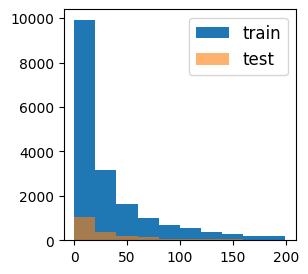

In [7]:
# prepare data
folder = 'nonlinear'
keywords = ['sine', "latest", '20000']
DATANAME = 'nl-sine'
# train_df, val_df, test_df = load_simulate_survival_data(folder=folder, keywords=keywords, val_split=True)
train_df, test_df = load_simulate_survival_data(folder=folder, keywords=keywords, test_size=0.1)
plot_simulation_data(train_df, test_df)

In [11]:
subset = [50, 500, 1000, 2000, 5000]
batch_sizes =[8, 16, 16, 32, 64]
runs = [20,20,10,10,10]
hyperparams = {
    "learning_rate": {"type": "float", "low": 1e-4, "high": 1e-2, "log": True},
    # "num_nodes": {"type": "categorical", "choices": [[32,32], [16,16]]},
    "dropout": {"type": "categorical", "choices": [0.1,0.5]},
    # "batch_size": {'type': "categorical", "choices": [32,64,128]}
}

In [12]:
best_params_ls, n_train, model_time, train_scores, test_scores = [],[],[],[],[]

for (n, batch_size, n_run) in zip(subset, batch_sizes, runs): 
    
    run_train_scores, run_test_scores, run_time = [],[],[]
    for run in range(n_run+1):
        if n < train_df.shape[0]:
            train_sub,_ = train_test_split(train_df,
                                        train_size=n/train_df.shape[0], 
                                        shuffle=True, random_state=run,
                                        stratify=train_df[status_col])
        else:
            train_sub = train_df
        
        ds = DeepSurvPipeline(train_sub, test_df, hyperparameters=hyperparams, dataName=DATANAME)
        if run == 0:
            study = ds.tune_hyperparameters(train_sub, n_trials=15, n_jobs=16)
            best_params = study.best_params
            best_params_ls.append(best_params)
            continue
        duration, train_c, test_c = ds.train_with_best_params(params=best_params, verbose=False, print_scores=False)
        
        n_train.append(n)
        model_time.append(duration)
        train_scores.append(train_c)
        test_scores.append(test_c)
            
        run_train_scores.append(train_c)
        run_test_scores.append(test_c)
        run_time.append(duration)
    
    print(f"N={n} Training time ({np.mean(run_time)}s): Train C-Index: {round(np.mean(run_train_scores),3)} | Test C-index: {round(np.mean(run_test_scores),3)} (Mean)")                

# ============== Save results ===============
model_results = pd.DataFrame({
    'n train': n_train, 
    'train time':model_time,
    'train score':train_scores, 
    'test score':test_scores}
)

[I 2025-01-06 14:53:44,227] Using an existing study with name 'nl-sine-50' instead of creating a new one.
[I 2025-01-06 14:57:28,994] Trial 19 finished with value: 0.6337471467715943 and parameters: {'learning_rate': 0.009876429178379394, 'dropout': 0.1}. Best is trial 0 with value: 0.6656712775854443.
[I 2025-01-06 14:57:29,019] Trial 23 finished with value: 0.6425429700010676 and parameters: {'learning_rate': 0.009532062030884286, 'dropout': 0.1}. Best is trial 0 with value: 0.6656712775854443.
[I 2025-01-06 14:57:29,372] Trial 24 finished with value: 0.6229473277514272 and parameters: {'learning_rate': 0.008976126498747267, 'dropout': 0.1}. Best is trial 0 with value: 0.6656712775854443.
[I 2025-01-06 14:57:29,828] Trial 26 finished with value: 0.605916413752434 and parameters: {'learning_rate': 0.009722308780796544, 'dropout': 0.1}. Best is trial 0 with value: 0.6656712775854443.
[I 2025-01-06 14:57:29,998] Trial 20 finished with value: 0.5714417890568206 and parameters: {'learning

Best trial parameters: {'learning_rate': 0.00886724216079615, 'dropout': 0.1}


[I 2025-01-06 14:58:29,131] Using an existing study with name 'nl-sine-500' instead of creating a new one.


N=50 Training time (0.17099999999999999s): Train C-Index: 0.786 | Test C-index: 0.527 (Mean)


[I 2025-01-06 15:01:58,718] Trial 15 finished with value: 0.6523410640237289 and parameters: {'learning_rate': 0.0077837792012293615, 'dropout': 0.5}. Best is trial 7 with value: 0.668171101680351.
[I 2025-01-06 15:02:26,661] Trial 22 finished with value: 0.649542363533502 and parameters: {'learning_rate': 0.009521170852416732, 'dropout': 0.5}. Best is trial 7 with value: 0.668171101680351.
[I 2025-01-06 15:02:35,870] Trial 18 finished with value: 0.6724453783943023 and parameters: {'learning_rate': 0.009822696674976527, 'dropout': 0.5}. Best is trial 18 with value: 0.6724453783943023.
[I 2025-01-06 15:02:36,057] Trial 21 finished with value: 0.6482179749327848 and parameters: {'learning_rate': 0.008031006448107784, 'dropout': 0.5}. Best is trial 18 with value: 0.6724453783943023.
[I 2025-01-06 15:02:36,431] Trial 23 finished with value: 0.6621530798102293 and parameters: {'learning_rate': 0.009787515430900343, 'dropout': 0.5}. Best is trial 18 with value: 0.6724453783943023.
[I 2025-0

Best trial parameters: {'learning_rate': 0.004052497934739238, 'dropout': 0.5}


[I 2025-01-06 15:03:54,304] Using an existing study with name 'nl-sine-1000' instead of creating a new one.


N=500 Training time (1.1609999999999998s): Train C-Index: 0.746 | Test C-index: 0.608 (Mean)


[I 2025-01-06 15:10:24,509] Trial 26 finished with value: 0.6648244143842823 and parameters: {'learning_rate': 0.003519143766607783, 'dropout': 0.5}. Best is trial 9 with value: 0.6708340401084949.
[I 2025-01-06 15:10:52,002] Trial 25 finished with value: 0.6645977973805316 and parameters: {'learning_rate': 0.002772738870260153, 'dropout': 0.5}. Best is trial 9 with value: 0.6708340401084949.
[I 2025-01-06 15:10:53,212] Trial 19 finished with value: 0.664679412386522 and parameters: {'learning_rate': 0.0025587839621954806, 'dropout': 0.5}. Best is trial 9 with value: 0.6708340401084949.
[I 2025-01-06 15:10:53,316] Trial 20 finished with value: 0.6641953725096286 and parameters: {'learning_rate': 0.002843557499319933, 'dropout': 0.5}. Best is trial 9 with value: 0.6708340401084949.
[I 2025-01-06 15:10:54,110] Trial 16 finished with value: 0.6647473047343276 and parameters: {'learning_rate': 0.0024956910293708425, 'dropout': 0.5}. Best is trial 9 with value: 0.6708340401084949.
[I 2025-0

Best trial parameters: {'learning_rate': 0.0027288713850125833, 'dropout': 0.5}


[I 2025-01-06 15:11:53,074] Using an existing study with name 'nl-sine-2000' instead of creating a new one.


N=1000 Training time (2.143s): Train C-Index: 0.741 | Test C-index: 0.636 (Mean)


[I 2025-01-06 15:20:46,889] Trial 18 finished with value: 0.6674268680857102 and parameters: {'learning_rate': 0.002078143148163079, 'dropout': 0.5}. Best is trial 5 with value: 0.6677392564902191.
[I 2025-01-06 15:21:07,864] Trial 25 finished with value: 0.6657773425493108 and parameters: {'learning_rate': 0.0019078343574118685, 'dropout': 0.5}. Best is trial 5 with value: 0.6677392564902191.
[I 2025-01-06 15:21:10,666] Trial 20 finished with value: 0.6650071008709947 and parameters: {'learning_rate': 0.0018863399086816062, 'dropout': 0.5}. Best is trial 5 with value: 0.6677392564902191.
[I 2025-01-06 15:21:15,080] Trial 24 finished with value: 0.6675156167966122 and parameters: {'learning_rate': 0.0021128431860265155, 'dropout': 0.5}. Best is trial 5 with value: 0.6677392564902191.
[I 2025-01-06 15:21:23,036] Trial 29 finished with value: 0.6685530572463612 and parameters: {'learning_rate': 0.0021163475800993394, 'dropout': 0.5}. Best is trial 29 with value: 0.6685530572463612.
[I 20

Best trial parameters: {'learning_rate': 0.0023014017155613144, 'dropout': 0.5}


[I 2025-01-06 15:22:57,183] Using an existing study with name 'nl-sine-5000' instead of creating a new one.


N=2000 Training time (5.345000000000001s): Train C-Index: 0.723 | Test C-index: 0.655 (Mean)


[I 2025-01-06 15:34:46,226] Trial 29 finished with value: 0.6371754677906013 and parameters: {'learning_rate': 0.006861186579051638, 'dropout': 0.5}. Best is trial 10 with value: 0.6768435515025389.
[I 2025-01-06 15:36:37,134] Trial 26 finished with value: 0.6802124875593525 and parameters: {'learning_rate': 0.0011589206071232186, 'dropout': 0.1}. Best is trial 26 with value: 0.6802124875593525.
[I 2025-01-06 15:37:21,734] Trial 19 finished with value: 0.6755426111746722 and parameters: {'learning_rate': 0.0008205625979236326, 'dropout': 0.1}. Best is trial 26 with value: 0.6802124875593525.
[I 2025-01-06 15:37:22,430] Trial 28 finished with value: 0.674576251549191 and parameters: {'learning_rate': 0.0011162232884864077, 'dropout': 0.1}. Best is trial 26 with value: 0.6802124875593525.
[I 2025-01-06 15:37:23,529] Trial 23 finished with value: 0.6677608913280699 and parameters: {'learning_rate': 0.003731021908434111, 'dropout': 0.1}. Best is trial 26 with value: 0.6802124875593525.
[I 

Best trial parameters: {'learning_rate': 0.0011589206071232186, 'dropout': 0.1}
N=5000 Training time (8.145s): Train C-Index: 0.727 | Test C-index: 0.673 (Mean)


In [13]:
model_results

,n train,train time,train score,test score
0,50,0.14,0.729927,0.494439
1,50,0.23,0.934426,0.556693
2,50,0.15,0.766617,0.496857
3,50,0.31,0.968701,0.561426
4,50,0.21,0.919162,0.494433
...,...,...,...,...
65,5000,9.61,0.740225,0.676605
66,5000,9.10,0.743808,0.689109
67,5000,7.70,0.731404,0.680263
68,5000,10.43,0.756007,0.677074


In [14]:
ds.write(model_results=model_results, fileName="model.results.10runs.txt")

In [26]:
model_params = pd.DataFrame(
    {'n train': subset,
    'hyperparameters': best_params_ls}
    )
model_params.to_csv(os.path.join('models', DATANAME, 'deepsurv-torch', 'model.hyperparameters.csv'))
model_params

,n train,hyperparameters
0,50,"{'learning_rate': 0.00886724216079615, 'dropou..."
1,500,"{'learning_rate': 0.004052497934739238, 'dropo..."
2,1000,"{'learning_rate': 0.0027288713850125833, 'drop..."
3,2000,"{'learning_rate': 0.0023014017155613144, 'drop..."
4,5000,"{'learning_rate': 0.0011589206071232186, 'drop..."
